# Lab 08: Web Scraping Wikipedia

You will need the following packages installed into your conda environment:

* scikit-learn
* yellowbrick
* BeautifulSoup4

I would like you to examine whether or not there is a linear correlation between the size of a US state and the year it was admitted to the union.  That is to say, were larger states admitted into the United States later than smaller states?  If there is a linear relationship, we can say this is the case.

Objectives: 
+ Scraping a table from a webpage
+ Storing that data in a dataframe
+ Performing a linear regression on that data







In [1]:
import urllib
import matplotlib.pylab as plt
from bs4 import BeautifulSoup
import bs4
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [7]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

## Part A
Using the URL I've provided below, I want you to scrape:
1. The name of each state
2. The year of admittance for each state
3. The land area for each state

Examine the URL to the webpage I've provided using your browser's element inspector to determine how to parse the relavent table.  

Store the data collected in a Pandas' DataFrame.


In [3]:
# Write your solution here.  
# You may need to use multiple cells to keep track of your efforts.
url='https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States'

In [8]:
with urllib.request.urlopen(url) as response:
    content_type = response.info()['Content-Type']
    soup = BeautifulSoup(response.read())
print('Content type:  ', content_type)
print('Page Title:    ', soup.title.text)


Content type:   text/html; charset=UTF-8
Page Title:     List of states and territories of the United States - Wikipedia


In [9]:
tables = soup.find_all('table', {'class':'wikitable sortable plainrowheaders'})
len(tables)

4

In [10]:
captions = soup.find_all('caption')
captions

[<caption>States of the United States of America
 </caption>,
 <caption>Federal district of the United States
 </caption>,
 <caption>Inhabited territories of the United States
 </caption>,
 <caption>Territories of the United States with no indigenous population
 </caption>,
 <caption>Territories claimed but not administered by the United States
 </caption>]

In [11]:
#  There are five different captions.  It looks like caption[0] is the
# one for the table we are interested in
captions[0]
table = captions[0].parent
table_body = table.tbody
state_rows = table_body.find_all('tr')[2:]
len(state_rows)

col_year = 3
col_size = 5

df = pd.DataFrame(columns=['state', 'year', 'size'])

years = []
states = []
sizes = []

for ndx, row in enumerate(state_rows):
    state = row.th.text
    row_td = row.find_all('td')
    cities_td = row_td[1]

    col_span =  int(cities_td.attrs['colspan']) if 'colspan' in cities_td.attrs else 1

    # col_span = 2 means the largest and capital city are the same and span two columns
    # col_span = 1 means they are different and occupy two columns
    rel_year = col_year - (col_span-1)
    rel_size = col_size - (col_span-1)

    admission = int(row_td[rel_year].text.split(',')[-1])
    state_size = int(row_td[rel_size].text.replace(',', ''))

    states.append(state.strip())
    years.append(admission)
    sizes.append(state_size)

df['state'] = states
df['year'] = years
df['size'] = sizes

df.head()

,state,year,size
0,Alabama,1819,52420
1,Alaska,1959,665384
2,Arizona,1912,113990
3,Arkansas,1836,53179
4,California,1850,163695


## Part B

Now that we have our data, we can go about plotting it and doing a regression on it.  We're not going to separate test and training data because we're really only interested in the regression line, not how well the regression performs on unseen data. 

I'd like you to use the Ridge linear model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

And I'd like you to follow the histogram plot example on this page: https://www.scikit-yb.org/en/latest/api/regressor/residuals.html# to check whether or not our residuals (error) are normally distributed (as they should be in a "good" linear regression)

**We will not be splitting the data set into testing and training.**  Only use the "training" data -- so 100% of the data is training.

In [12]:
# Because this is univariate data, we need to first
# transform our input data into 1-dimensional arrays
# If your DataFrame is called df and has columns YearsFounded and SizeMi2
# You can use the following
# x_vals = df['YearFounded'].to_numpy().reshape(-1,1)
# y_vals = df['SizeMi2'].to_numpy().reshape(-1,1)

vec_founded = df['year'].to_numpy().reshape(-1,1)  # Hey we have 50 observations with 1 attribute
vec_founded

vec_size = df['size'].to_numpy().reshape(-1,1)
vec_size

array([[ 52420],
       [665384],
       [113990],
       [ 53179],
       [163695],
       [104094],
       [  5543],
       [  2489],
       [ 65758],
       [ 59425],
       [ 10932],
       [ 83569],
       [ 57914],
       [ 36420],
       [ 56273],
       [ 82278],
       [ 40408],
       [ 52378],
       [ 35380],
       [ 12406],
       [ 10554],
       [ 96714],
       [ 86936],
       [ 48432],
       [ 69707],
       [147040],
       [ 77348],
       [110572],
       [  9349],
       [  8723],
       [121590],
       [ 54555],
       [ 53819],
       [ 70698],
       [ 44826],
       [ 69899],
       [ 98379],
       [ 46054],
       [  1545],
       [ 32020],
       [ 77116],
       [ 42144],
       [268596],
       [ 84897],
       [  9616],
       [ 42775],
       [ 71298],
       [ 24230],
       [ 65496],
       [ 97813]], dtype=int64)

In [13]:
# Use the Ridge linear regression model from skit-learn
# Then print out the model coefficients and intercept
# You will have to call fit() on the model and then
# look at the attributes in the documentation
# Also look at our regression score
regression = linear_model.Ridge()
regression.fit(vec_founded, vec_size)

print('Coef:      ', regression.coef_)
print('Intercept: ', regression.intercept_)
print('R^2:       ', regression.score(vec_founded, vec_size))

Coef:       [[1082.78777626]]
Intercept:  [-1916071.15198103]
R^2:        0.2833897372903159


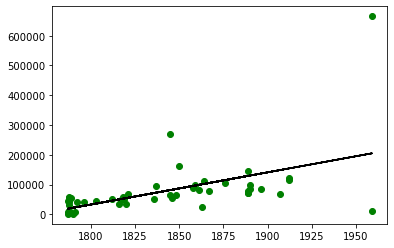

In [14]:
# Let's plot our result to see our fit
# if x_vals and y_vals are your data sets and
# regression is the name of your linear model
# This will plot the data points and the best fit line
#
plt.scatter(vec_founded, vec_size, color='g', label=df['state'])   # to plot the data
plt.plot(vec_founded, regression.predict(vec_founded), 'k') # to plot the regression

In [ ]:
pip install yellowbrick

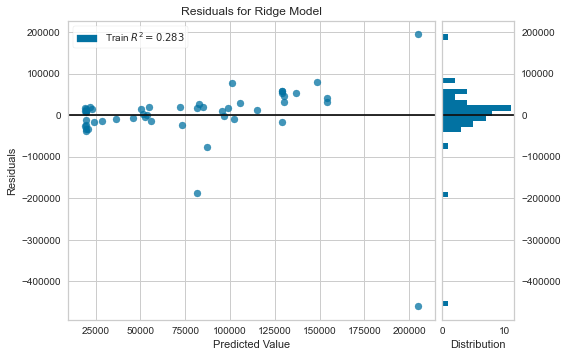

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
# Let's check our residuals with a histogram
# You can use the following code
# if x_vals and y_vals are your data sets
#

from yellowbrick.regressor import ResidualsPlot


model = linear_model.Ridge()
visualizer = ResidualsPlot(model, hist=True)
visualizer.fit(vec_founded, vec_size)
visualizer.show()
#
# If our linear model is valid, then the residuals should
# be normally distributed.  The histogram on the right
# should be a normal distribution.  Is it?  Or are there outliers?